In [15]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
import numpy as np
from numba import njit

seed=42
max_iter=128
converge=1e-30


@njit(fastmath=True)
def fl_coeff_vsk(b, c, d):
    """
    Calculate the variance, skew and kurtosis of a Fleishman Polynomial.

    F = -c + bX + cX^2 + dX^3, where X ~ N(0,1)
    """
    var = (b**2) + 6 * (b * d) + 2 * (c**2) + 15 * (d**2)
    skew = 2 * c * ((b**2) + 24 * (b * d) + 105 * (d**2) + 2)
    ekurt = 24 * (
        (b * d)
        + (c**2) * (1 + (b**2) + 28 * (b * d))
        + (d**2) * (12 + 48 * (b * d) + 141 * (c**2) + 225 * (d**2))
    )
    return (var, skew, ekurt)

@njit(fastmath=True)
def fl_func(b, c, d, skew, ekurt):
    """
    Define a function that will have roots if the coeffs give the desired skew and kurtosis.
    """
    var, skew_calc, ekurt_calc = fl_coeff_vsk(b, c, d)
    return np.array([var - 1, skew_calc - skew, ekurt_calc - ekurt])

@njit(fastmath=True)
def fl_deriv(b, c, d):
    """
    Calculate the partial derivatives of the fl_func above.
    """
    b2 = b * b
    c2 = c * c
    d2 = d * d
    bd = b * d

    df1db = 2 * b + 6 * d
    df1dc = 4 * c
    df1dd = 6 * b + 30 * d

    df2db = 4 * c * (b + 12 * d)
    df2dc = 2 * (b2 + 24 * bd + 105 * d2 + 2)
    df2dd = 4 * c * (12 * b + 105 * d)

    df3db = 24 * (d + c2 * (2 * b + 28 * d) + 48 * d2)
    df3dc = 48 * c * (1 + b2 + 28 * bd + 141 * d2)
    df3dd = 24 * (
        b
        + 28 * b * c2
        + 2 * d * (12 + 48 * bd + 141 * c2 + 225 * d2)
        + d2 * (48 * b + 450 * d)
    )

    return np.array(
        [[df1db, df1dc, df1dd], [df2db, df2dc, df2dd], [df3db, df3dc, df3dd]]
    )

@njit(parallel=True, fastmath=True)
def newton(b0, c0, d0, skew, ekurt, max_iter, converge):
    """Implements Newton's method to find a root of fl_func."""
    i = 0
    f = fl_func(b0, c0, d0, skew, ekurt)
    while np.abs(f).max() > converge and i < max_iter:
        J = fl_deriv(b0, c0, d0)
        delta = -1 * np.linalg.solve(J, f)
        b0, c0, d0 = delta + np.array([b0, c0, d0])
        f = fl_func(b0, c0, d0, skew, ekurt)
        i += 1

    return b0, c0, d0

@njit(fastmath=True)
def fl_ic(skew, ekurt):
    """Initial condition estimate of the Fleishman coefficients."""
    b0 = (
        0.95357
        - 0.05679 * ekurt
        + 0.03520 * skew**2
        + 0.00133 * ekurt**2
    )
    c0 = 0.10007 * skew + 0.00844 * skew**3
    d0 = 0.30978 - 0.31655 * b0

    return (b0, c0, d0)

@njit(fastmath=True, parallel=True)
def gen_field(size, mean, var, skew, ekurt, rng):
    """Generate the non-normal Fleishman field."""
    ekurt_thresh = -1.13168 + 1.58837 * skew**2
    
    ekurt = max([ekurt, 10])
    if (ekurt < ekurt_thresh):
        return np.random.normal(loc=mean, scale=np.sqrt(var), size=size)
    # ekurt_thresh = -1.13168 + 1.58837 * skew**2

    # if ekurt < ekurt_thresh:
    #     raise ValueError(
    #         f"For the Fleishman method to function with:\n\tmean: {mean:.2f}\n\tvari: {var:.2f}\n\tskew: {skew:.2f}\nThe value of [ekurt] must be >= [{ekurt_thresh:.4f}]"
    #     )

    # else:
    X = rng.normal(size=int(size))

    b0, c0, d0 = fl_ic(skew, ekurt)
    b, c, d = newton(b0, c0, d0, skew, ekurt, max_iter, converge)

    field = (-1 * c + X * (b + X * (c + X * d))) * np.sqrt(var) + mean

    # Stats of the generated non-normal field
    # mean = np.mean(field)
    # mu_2 = np.mean((field - mean) ** 2)
    # mu_3 = np.mean((field - mean) ** 3)
    # mu_4 = np.mean((field - mean) ** 4)

    # var = mu_2
    # skew = mu_3 / (var**1.5)
    # ekurt = mu_4 / (var**2) - 3

    # {
    #     "mean": mean,
    #     "var": var,
    #     "skew": skew,
    #     "ekurt": ekurt,
    # }
    return field

In [17]:
mean = 0
var = 1
skew = 1
ekurt = 2
size = 2**20

# Create an instance of the Fleishman class

# Generate the field
non_normal_data = gen_field(size, mean, var, skew, ekurt, np.random.default_rng(seed))


In [18]:

# Gram-Schmidt orthogonalization functionabs
def gram_schmidt(vectors):
    orthogonal = []
    for v in vectors:
        for u in orthogonal:
            v = v - np.dot(u, v) / np.dot(u, u) * u
        orthogonal.append(v)
    return np.array(orthogonal)

# Function to add noise while preserving covariance and higher moments
def add_noise_preserve_moments_multivariate(X, noise_level=0.01):
    """
    Add noise to multivariate financial data while preserving the first four moments
    and the covariance structure.
    
    X: np.array, original data (2D array where each column is a variable)
    noise_level: float, scaling factor for noise
    """
    # Step 1: Standardize the data to have mean 0 and variance 1
    
    # Step 3: Generate noise and adjust it with Cholesky decomposition to match covariance structure
    mean =np.mean(X, axis=0) # Mean of the original data
    std = np.std(X, axis=0) # Standard deviation of the original data
    skew = stats.skew(X, axis=0) # Kurtosis of the original data
    kurt = stats.kurtosis(X, axis=0) # Skewness of the original data
    
    # noise = np.random.normal(0, 1, X.shape)
    noise = np.empty_like(X)
    for i in tqdm(range(X.shape[1])):
        if kurt[i] < 50:
            ff = gen_field(size = X.shape[0], mean = mean[i], var = np.sqrt(std)[i], skew = skew[i], ekurt = kurt[i], rng = np.random.default_rng(seed))
        else: # normal distribution with mean and std
            ff = np.random.normal(mean[i], np.sqrt(std[i]), X.shape[0])
        noise[:, i] = ff
    
    X_std = (X - mean) / std
    
    # Step 2: Compute the covariance matrix of the original standardized data
    cov_matrix = np.cov(X_std, rowvar=False)
    
    L = np.linalg.cholesky(cov_matrix)  # Cholesky decomposition
    noise_cov_adjusted = noise @ L.T  # Adjust noise to preserve covariance structure
    
    # Step 4: Apply Gram-Schmidt orthogonalization to the noise to preserve higher-order moments
    combined_data = np.vstack([X_std.T, noise_cov_adjusted.T])  # Stacking rows (for orthogonalization)
    orthogonalized_noise = gram_schmidt(combined_data)[len(X_std.T):]  # Only keep orthogonalized noise part
    
    # Step 5: Add the orthogonalized noise to the original standardized data
    Y = X_std + orthogonalized_noise.T * noise_level
    
    # Step 6: Rescale the data back to its original scale
    Y_rescaled = Y * std + mean
    
    # Adjust for both variance and covariance preservation
    Y_rescaled = correct_covariance(X, Y_rescaled)
    
    return Y_rescaled

# Function to adjust the covariance after noise is added
def correct_covariance(X, Y):
    """
    Correct both variance and covariance of the noisy data Y to match the original data X.
    
    X: np.array, original data (before adding noise)
    Y: np.array, noisy data (after adding noise)
    """
    # Compute the covariance matrices of X and Y
    cov_X = np.cov(X, rowvar=False)
    cov_Y = np.cov(Y, rowvar=False)
    
    # Whitening: Decorrelate Y by transforming it to have an identity covariance matrix
    cov_Y_inv_sqrt = np.linalg.inv(np.linalg.cholesky(cov_Y)).T  # Inverse Cholesky of cov_Y
    Y_whitened = (Y - np.mean(Y, axis=0)) @ cov_Y_inv_sqrt.T
    
    # Coloring: Apply the original covariance matrix of X to restore the correlation structure
    cov_X_sqrt = np.linalg.cholesky(cov_X)  # Cholesky of cov_X
    Y_colored = Y_whitened @ cov_X_sqrt.T + np.mean(X, axis=0)
    
    return Y_colored


# Example usage:
# np.random.seed(42)

# X_multivariate = np.random.multivariate_normal([0.05, 0.02], [[0.1, 0.01], [0.01, 0.1]], size=1000)
# Generate synthetic multivariate financial data (e.g., two asset returns)

# Add noise while preserving covariance structure and higher-order moments
# Y_multivariate = add_noise_preserve_moments_multivariate(X_multivariate, noise_level=1.0)

# # Checking moments before and after adding noise
# def print_moments(X, label):
#     print(f"\n{label} Moments:")
#     print(f"Mean: {np.mean(X, axis=0)}")
#     print(f"Variance: {np.var(X, axis=0)}")
#     print(f"Skewness: {stats.skew(X, axis=0)}")
#     print(f"Kurtosis: {stats.kurtosis(X, axis=0)}")
#     print(f"Covariance Matrix:\n{np.cov(X, rowvar=False)}\n")

# print_moments(X_multivariate, "Original Data")
# print_moments(Y_multivariate, "Noisy Data")


# x = pd.DataFrame(X_multivariate, columns= ['X1', 'X2'])
# y = pd.DataFrame(Y_multivariate, columns= ['Y1', 'Y2'])
# all_data = pd.concat([x, y], axis = 1)
# all_data.plot(alpha = 0.5)
# plt.show()

# (1 + all_data).cumprod().plot(alpha = 0.5)
# plt.show()

## real data

In [19]:
import pickle as pkl
with open('data_all.pkl','rb') as f:  #rb is read binary code
    cov_period, index_, returns = pkl.load(f)

# returns = returns[['EFA', 'EWJ', 'IWM', 'SPY', 'XLY']] #.iloc[:500] 
#basically convert all of returns to integer index
index_int=[x for x in range(len(returns.index))]

assets = ["AGG", "GLD", "LQD", "QQQ", "TIP", "VBR"]
returns = returns[assets]

In [20]:
X = returns.iloc[1:]

100%|██████████| 6/6 [00:02<00:00,  2.54it/s]



Original Data Moments:
Mean: [0.00011083 0.00033577 0.00014921 0.00055995 0.00013493 0.00043054]
Variance: [1.01258140e-05 1.26546875e-04 2.90823081e-05 1.87640218e-04
 1.56562043e-05 2.25647870e-04]
Skewness: [-2.51598091 -0.18518549  0.00546639 -0.17193715  0.20134783 -0.45542576]
Kurtosis: [68.29743977  6.29943168 69.02727119  7.42251681 10.77636227  9.05986408]

Noisy Data Moments:
Mean: [0.00011083 0.00033577 0.00014921 0.00055995 0.00013493 0.00043054]
Variance: [8.22524807e-06 1.03342956e-04 1.48319147e-05 1.14352048e-04
 1.39091510e-05 1.41880914e-04]
Skewness: [-0.5238202  -0.19943236  0.42415782 -0.22483982 -0.13530318 -0.49508018]
Kurtosis: [43.15204064  8.10837611 47.97825104  8.16309753 28.86520916 11.01185935]


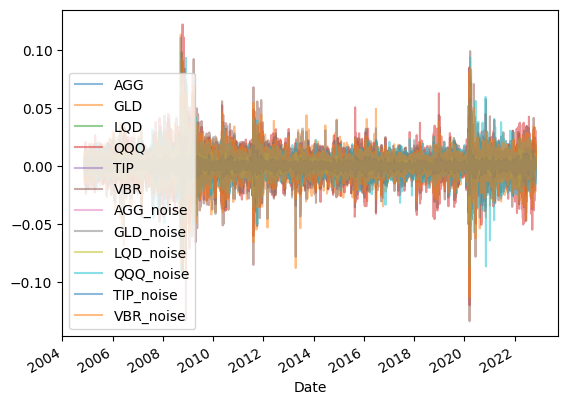

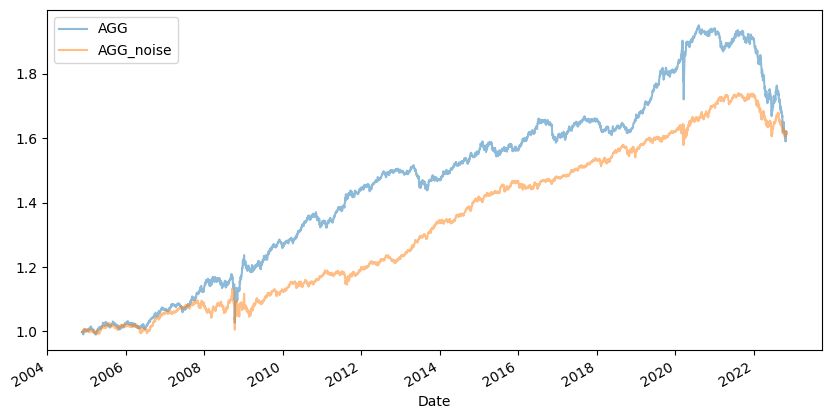

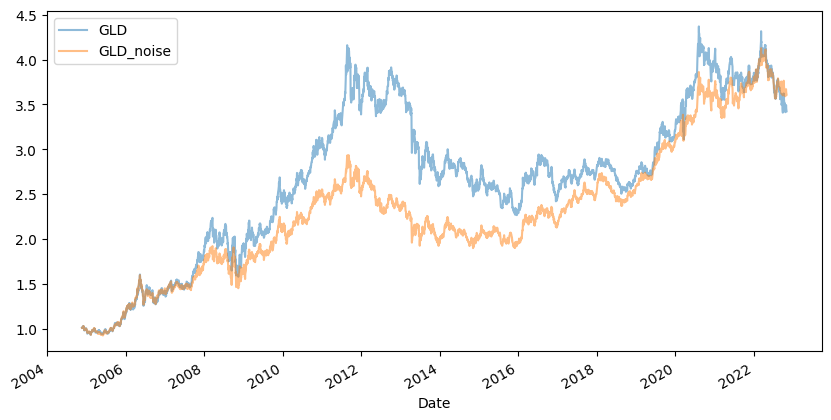

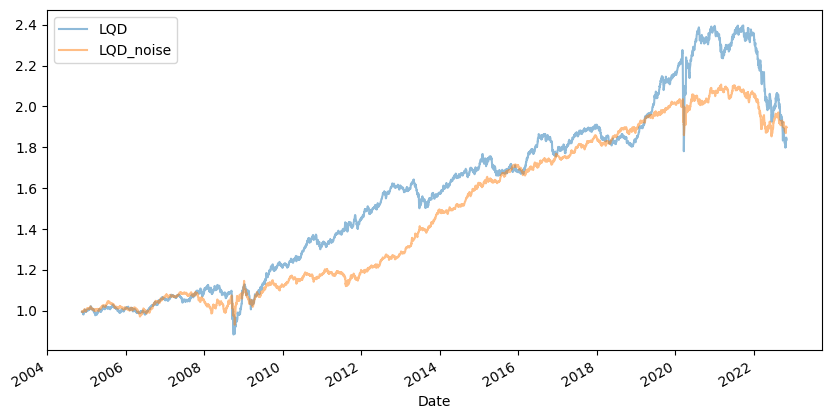

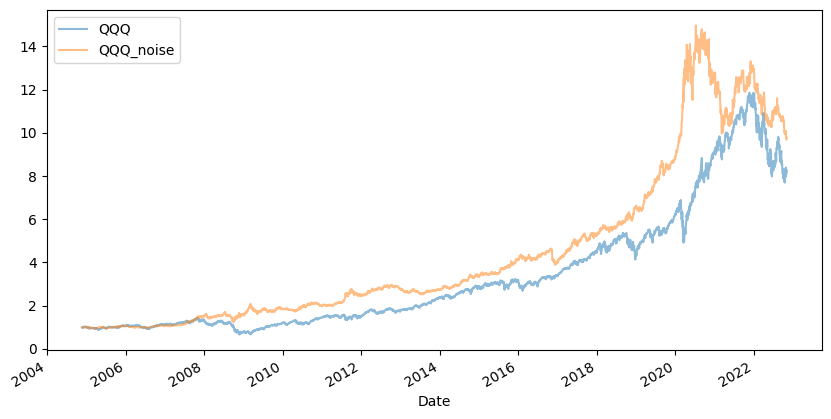

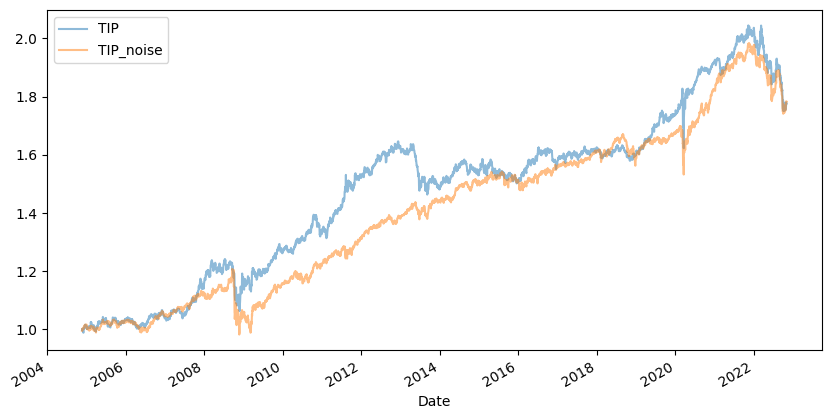

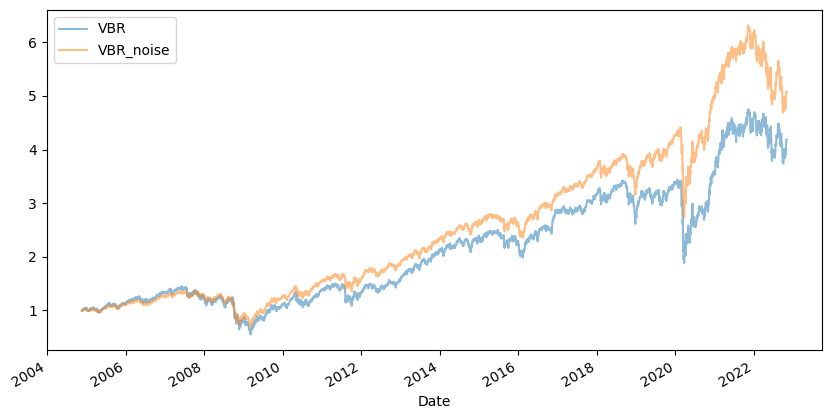

In [21]:
Y_multivariate = add_noise_preserve_moments_multivariate(X.to_numpy(), noise_level=1)
diffuse = np.array([0.8] * len(assets))
diffuse[0] = 0.2
diffuse[0] = 0.4
diffuse[-1] = 0.3
Y_multivariate = (1 - diffuse) * X.to_numpy() + diffuse * Y_multivariate
# Checking moments before and after adding noise
def print_moments(X, label):
    print(f"\n{label} Moments:")
    print(f"Mean: {np.mean(X, axis=0)}")
    print(f"Variance: {np.var(X, axis=0)}")
    print(f"Skewness: {stats.skew(X, axis=0)}")
    print(f"Kurtosis: {stats.kurtosis(X, axis=0)}")

print_moments(X.to_numpy(), "Original Data")
print_moments(Y_multivariate, "Noisy Data")


y = pd.DataFrame(Y_multivariate, columns = [ai + "_noise" for ai in assets], index = X.index)

all_data = pd.concat([X, y], axis = 1)
all_data.plot(alpha = 0.5)
plt.show()


ret_data = (1 + all_data).cumprod()

for ai in assets:
    ret_data[[ai, ai + "_noise"]].plot(alpha = 0.5, figsize=(10, 5))
    plt.show()

<Axes: xlabel='Date'>

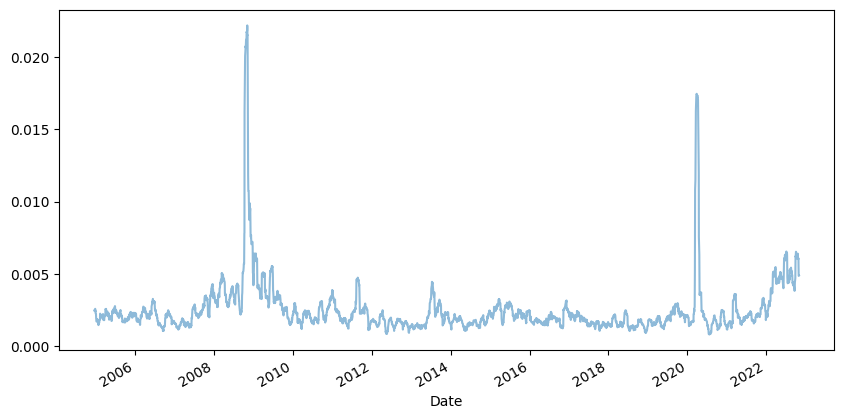

In [24]:
X["AGG"].rolling(21).std().plot(alpha = 0.5, figsize=(10, 5))

<Axes: xlabel='Date'>

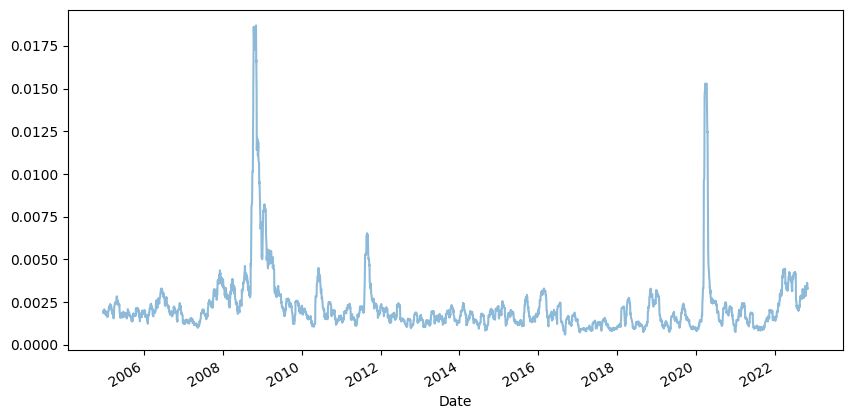

In [26]:
y["AGG_noise"].rolling(21).std().plot(alpha = 0.5, figsize=(10, 5))

In [96]:
X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\Toon\AppData\Local\Temp\ipykernel_21804\2694154310.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,AGG,GLD,LQD,QQQ,TIP,VBR
AGG,1.00,0.19,0.66,-0.04,0.64,-0.07
GLD,0.19,1.00,0.13,0.03,0.26,0.04
LQD,0.66,0.13,1.00,0.15,0.49,0.13
QQQ,-0.04,0.03,0.15,1.00,-0.14,0.80
TIP,0.64,0.26,0.49,-0.14,1.00,-0.13
VBR,-0.07,0.04,0.13,0.80,-0.13,1.00


In [63]:
y.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\Toon\AppData\Local\Temp\ipykernel_15656\2034640721.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  y.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,AGG_noise,GLD_noise,LQD_noise,QQQ_noise,TIP_noise,VBR_noise
AGG_noise,1.00,-0.09,0.47,0.09,0.48,0.14
GLD_noise,-0.09,1.00,-0.10,0.07,0.15,0.10
LQD_noise,0.47,-0.10,1.00,0.18,0.38,0.12
QQQ_noise,0.09,0.07,0.18,1.00,-0.00,0.71
TIP_noise,0.48,0.15,0.38,-0.00,1.00,0.13
VBR_noise,0.14,0.10,0.12,0.71,0.13,1.00
